# Section IV-A — Toy stationary renewable generation
Key features vs IV-B (non-stationary case):
- Constant mean-reversion level $m_k \equiv m$ (no DA forecast input).
- Constant dispatch target $M_k \equiv M$ for all time steps.
- Stationary additive-noise dynamics: $$X_{k+1}=X_k+\alpha(m-X_k)\Delta t+\sigma\,Z_k\sqrt{\Delta t}.$$
- Time-homogeneous regression design $\mathcal{D}$: same LHS state domain used at every step.

（Based on Thiha Aung & Mike Ludkovski, IEEE CDC 2024）

In [ ]:
# Cell 1: Imports
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Parameters 
# Model parameters
Delta_t = 0.25          # 15-minute intervals
n_steps = 96            # 24 hours → 96 steps

# Wind power parameters
alpha = 1.0
sigma = 1.0
m_k = 5.0               # constant mean reversion level
Mk = 5.0               # constant dispatch target

# SoC parameters
Icap = 8.0             # MWh
SoC_min = 0.05
SoC_max = 0.95
eta = 0.9
Bmax = 2.0
Bmin = -2.0

# Cost parameters
lambda_penalty = 50.0

# Initial condition
I0 = 0.1 * Icap

# LHS design parameters
X_min_design = 0.0
X_max_design = 10.0
I_min_design = 0.0
I_max_design = Icap
Nloc = 600             # number of unique sites (paper uses 600 - reduce for speed)
Nrep = 50              # replications (paper uses 50)

In [3]:
# Cell 3: Helper functions
# Wind power dynamics
def next_X(X_current, m_k, alpha, sigma, Delta_t):
    noise = np.random.normal(size=np.shape(X_current), scale=np.sqrt(Delta_t))
    return X_current + alpha * (m_k - X_current) * Delta_t + sigma * noise

# SoC dynamics
def next_I(I_current, B, Delta_t, eta):
    # Handle scalar case for simulation
    if np.isscalar(B):
        if B >= 0:
            return I_current + eta * B * Delta_t
        else:
            return I_current + B * Delta_t / eta
    # Vector case for simulation
    else:
        result = np.empty_like(np.array(B, dtype=float))
        mask = np.array(B) >= 0
        result[mask] = I_current[mask] + eta * B[mask] * Delta_t
        result[~mask] = I_current[~mask] + B[~mask] * Delta_t / eta
        return result

# Terminal cost
def terminal_penalty(IT):
    return lambda_penalty * max(0.1 * Icap - IT, 0)

# Get bounds on B given I
def get_bounds_approx(I_approx, Delta_t, eta, Icap, SoC_min, SoC_max, Bmin, Bmax):
    lower = max(Bmin, eta * (SoC_min * Icap - I_approx) / Delta_t)
    upper = min(Bmax, (SoC_max * Icap - I_approx) / (eta * Delta_t))
    return lower, upper

In [4]:
# Cell 4: Latin Hypercube Design (same for all steps in stationary case)
# Generate LHS design
def latin_hypercube(n_samples, dim, seed=None):
    rng = np.random.default_rng(seed)
    cut = np.linspace(0, 1, n_samples + 1)
    
    u = np.zeros((n_samples, dim))
    for j in range(dim):
        # Random point inside each interval for dimension j
        u[:, j] = rng.uniform(cut[:-1], cut[1:])
        # Randomly permute
        rng.shuffle(u[:, j])   
    return u

# Scale LHS to desired bounds
def scale_lhs(lhs, lower_bounds, upper_bounds):
    lower_bounds = np.asarray(lower_bounds)
    upper_bounds = np.asarray(upper_bounds)
    return lower_bounds + lhs * (upper_bounds - lower_bounds)

# Generate and scale design
design_base = latin_hypercube(Nloc, 2, seed=42)
X_I_base = scale_lhs(design_base,
                     [X_min_design, I_min_design],
                     [X_max_design, I_max_design])
X_base = X_I_base[:, 0]
I_next_base = X_I_base[:, 1]

In [5]:
# Cell 5: RMC Backward Loop

# ---------- Options ----------
resample_design_each_step = False  # keep stationary LHS by default
use_surrogate_for_pathwise_B = False  # we won't use surrogate for pathwise B here
n_restarts_control = 10 # Hyperparameter restarts for control GP
n_restarts_value = 10 # Hyperparameter restarts for value GP
opt_options = {'ftol': 1e-9, 'maxiter': 200}   # options for minimize (L-BFGS-B)
# -----------------------------

# pre-alloc
control_gps = [None] * n_steps
value_gps   = [None] * n_steps

def terminal_penalty_array(it_array):
    return np.array([terminal_penalty(float(x)) for x in np.atleast_1d(it_array)])

# Total number of replicates across all design points
N = Nloc * Nrep

# Backward induction over time steps
for t in range(n_steps - 1, -1, -1):
    print(f"Backward step t = {t} / {n_steps - 1}")

    # Generate design D_t
    X_I_design = X_I_base.copy()  # shape (Nloc, 2)
    X_t_loc = X_I_design[:, 0]   # X_t^i for i=0..Nloc-1
    I_t_loc = X_I_design[:, 1]   # I_t^i

    # Replicate each design location Nrep times to form pathwise simulation inputs
    # We'll create arrays of length N = Nloc * Nrep where replicates for location i occupy indices i*Nrep:(i+1)*Nrep
    X_current = np.repeat(X_t_loc, Nrep)   # shape (N,)
    I_current = np.repeat(I_t_loc, Nrep)   # shape (N,)

    # Simulate one-step forward X_t -> X_{t+1}
    # This will draw random normals inside next_X, producing pathwise X_next for each replicate
    X_next = next_X(X_current, m_k, alpha, sigma, Delta_t)  # shape (N,)

    # Compute an optimal scalar b_i for each design location i
    B_opt_per_loc = np.zeros(Nloc, dtype=float)

    # For each design location i, prepare indices and replicate data
    for i in range(Nloc):
        # replicate index range
        start = i * Nrep
        end = start + Nrep

        # data for this design location's replicates
        X_cur_rep = X_current[start:end]   # shape (Nrep,)
        X_next_rep = X_next[start:end]     # shape (Nrep,)
        I_cur_rep = I_current[start:end]   # shape (Nrep,) -- all equal to I_t_loc[i] typically

        # compute feasible bounds for this design location (using I at time t)
        lower_i, upper_i = get_bounds_approx(I_t_loc[i], Delta_t, eta, Icap, SoC_min, SoC_max, Bmin, Bmax)

        # if degenerate bounds, simply set to midpoint and skip optimization
        if lower_i >= upper_i:
            B_opt_per_loc[i] = 0.5 * (lower_i + upper_i)
            continue

        # Define objective for location i: average over replicates j
        # Note: we DO NOT enforce bounds inside the optimizer; we clip AFTER optimization
        def obj_scalar(b_array):
            # minimize expects array-like, but we just optimize scalar, so convert
            b = float(np.atleast_1d(b_array)[0])

            # immediate losses for each replicate j (L2 loss)
            immediate = (X_cur_rep - b - Mk) ** 2  # shape (Nrep,)

            # next inventories for each replicate given this single b
            I_next_rep = next_I(I_cur_rep, b, Delta_t, eta)  # shape (Nrep,) vectorized

            # continuation value for each replicate
            if t == n_steps - 1:
                # last decision step: continuation value is terminal penalty
                cont_rep = terminal_penalty_array(I_next_rep)
            else:
                # general case: use learned value function at t+1
                cont_rep = value_gps[t + 1].predict(np.column_stack((X_next_rep, I_next_rep))).flatten()

            # average pathwise cost across the Nrep replicates (this is the objective for location i)
            mean_cost = np.mean(immediate + cont_rep)
            return mean_cost

        # initial guess: midpoint of feasible interval
        x0 = np.array([0.5 * (lower_i + upper_i)])

        # Run scalar optimization using L-BFGS-B (no bounds passed)
        res = minimize(obj_scalar, x0=x0, method='L-BFGS-B', options=opt_options)
        b_hat = float(res.x[0])

        # Clip the result to feasible interval AFTER optimization (paper's approach)
        b_clipped = np.clip(b_hat, lower_i, upper_i)
        B_opt_per_loc[i] = b_clipped

    # Now we have one optimized control per design location (Nloc). Expand it to all replicates:
    B_pathwise = np.repeat(B_opt_per_loc, Nrep)  # shape (N,)

    # Compute pathwise immediate loss, next inventory and continuation 
    I_next_all = next_I(I_current, B_pathwise, Delta_t, eta)  # vectorized shape (N,)
    loss_all = (X_current - B_pathwise - Mk) ** 2

    if t == n_steps - 1:
        cont_all = terminal_penalty_array(I_next_all)
    else:
        cont_all = value_gps[t + 1].predict(np.column_stack((X_next, I_next_all))).flatten()

    v_all = loss_all + cont_all  # pathwise costs (N,)

    # Average over replicates -> regression targets of length Nloc 
    B_avg = B_pathwise.reshape(Nloc, Nrep).mean(axis=1)   # equals B_opt_per_loc basically
    v_avg = v_all.reshape(Nloc, Nrep).mean(axis=1)

    # Fit control GP (Matérn 3/2) 
    control_kernel = Matern(length_scale=1.0, nu=1.5)
    control_gp = GaussianProcessRegressor(kernel=control_kernel,
                                          n_restarts_optimizer=n_restarts_control,
                                          random_state=42)
    control_gp.fit(X_I_design, B_avg)   # inputs shape (Nloc,2)
    control_gps[t] = control_gp

    #  Fit value GP (Matérn 5/2) at EVERY decision step 
    value_kernel = Matern(length_scale=[1.0, 1.0], nu=2.5)
    value_gp = GaussianProcessRegressor(kernel=value_kernel,
                                        n_restarts_optimizer=n_restarts_value,
                                        random_state=42)
    value_gp.fit(X_I_design, v_avg)
    value_gps[t] = value_gp

    print(f"Completed t={t}: optimized {Nloc} locations, fitted control GP and value GP")

print("Backward pass completed: control_gps and value_gps ready.")


Backward step t = 95 / 95
Completed t=95: optimized 600 locations, fitted control GP and value GP
Backward step t = 94 / 95
Completed t=94: optimized 600 locations, fitted control GP and value GP
Backward step t = 93 / 95
Completed t=93: optimized 600 locations, fitted control GP and value GP
Backward step t = 92 / 95
Completed t=92: optimized 600 locations, fitted control GP and value GP
Backward step t = 91 / 95
Completed t=91: optimized 600 locations, fitted control GP and value GP
Backward step t = 90 / 95
Completed t=90: optimized 600 locations, fitted control GP and value GP
Backward step t = 89 / 95
Completed t=89: optimized 600 locations, fitted control GP and value GP
Backward step t = 88 / 95
Completed t=88: optimized 600 locations, fitted control GP and value GP
Backward step t = 87 / 95
Completed t=87: optimized 600 locations, fitted control GP and value GP
Backward step t = 86 / 95
Completed t=86: optimized 600 locations, fitted control GP and value GP
Backward step t = 85

d:\Documents\Udem\IFT6162\Final Project\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 6 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Completed t=25: optimized 600 locations, fitted control GP and value GP
Backward step t = 24 / 95
Completed t=24: optimized 600 locations, fitted control GP and value GP
Backward step t = 23 / 95
Completed t=23: optimized 600 locations, fitted control GP and value GP
Backward step t = 22 / 95
Completed t=22: optimized 600 locations, fitted control GP and value GP
Backward step t = 21 / 95
Completed t=21: optimized 600 locations, fitted control GP and value GP
Backward step t = 20 / 95
Completed t=20: optimized 600 locations, fitted control GP and value GP
Backward step t = 19 / 95


d:\Documents\Udem\IFT6162\Final Project\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Completed t=19: optimized 600 locations, fitted control GP and value GP
Backward step t = 18 / 95
Completed t=18: optimized 600 locations, fitted control GP and value GP
Backward step t = 17 / 95
Completed t=17: optimized 600 locations, fitted control GP and value GP
Backward step t = 16 / 95
Completed t=16: optimized 600 locations, fitted control GP and value GP
Backward step t = 15 / 95
Completed t=15: optimized 600 locations, fitted control GP and value GP
Backward step t = 14 / 95
Completed t=14: optimized 600 locations, fitted control GP and value GP
Backward step t = 13 / 95
Completed t=13: optimized 600 locations, fitted control GP and value GP
Backward step t = 12 / 95
Completed t=12: optimized 600 locations, fitted control GP and value GP
Backward step t = 11 / 95
Completed t=11: optimized 600 locations, fitted control GP and value GP
Backward step t = 10 / 95
Completed t=10: optimized 600 locations, fitted control GP and value GP
Backward step t = 9 / 95


d:\Documents\Udem\IFT6162\Final Project\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Completed t=9: optimized 600 locations, fitted control GP and value GP
Backward step t = 8 / 95
Completed t=8: optimized 600 locations, fitted control GP and value GP
Backward step t = 7 / 95
Completed t=7: optimized 600 locations, fitted control GP and value GP
Backward step t = 6 / 95
Completed t=6: optimized 600 locations, fitted control GP and value GP
Backward step t = 5 / 95


d:\Documents\Udem\IFT6162\Final Project\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 0 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Completed t=5: optimized 600 locations, fitted control GP and value GP
Backward step t = 4 / 95
Completed t=4: optimized 600 locations, fitted control GP and value GP
Backward step t = 3 / 95
Completed t=3: optimized 600 locations, fitted control GP and value GP
Backward step t = 2 / 95
Completed t=2: optimized 600 locations, fitted control GP and value GP
Backward step t = 1 / 95
Completed t=1: optimized 600 locations, fitted control GP and value GP
Backward step t = 0 / 95
Completed t=0: optimized 600 locations, fitted control GP and value GP
Backward pass completed: control_gps and value_gps ready.


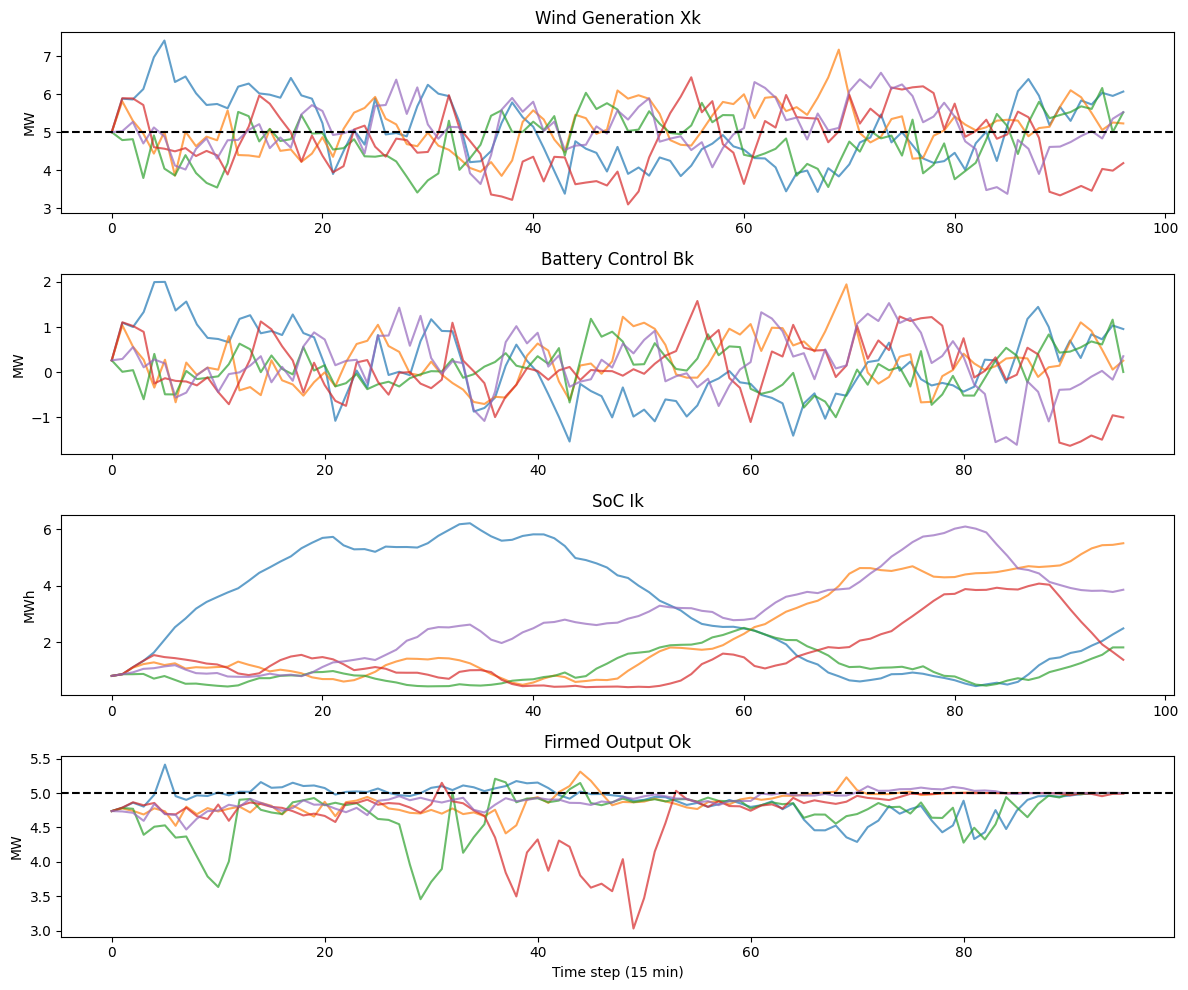

In [6]:
# Cell 6: Simulate paths with learned policy (out-of-sample evaluation) - Monte carlo simulation
def simulate_path(X_start=5.0, I_start=I0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X_path = [X_start]
    I_path = [I_start]
    B_path = []
    O_path = []
    
    X = float(X_start)
    I = float(I_start)
    
    for step in range(n_steps):
        # Predict raw control from GP
        B_raw = float(control_gps[step].predict([[X, I]])[0])
        # Enforce feasible control bounds implied by SoC constraints
        lower, upper = get_bounds_approx(I, Delta_t, eta, Icap, SoC_min, SoC_max, Bmin, Bmax)
        B = float(np.clip(B_raw, lower, upper))
        O = X - B
        
        B_path.append(B)
        O_path.append(O)
        
        X = next_X(X, m_k, alpha, sigma, Delta_t)
        I = next_I(I, B, Delta_t, eta)
        # numerical safety (should already be satisfied if B is clipped)
        I = float(np.clip(I, SoC_min * Icap, SoC_max * Icap))
        
        X_path.append(X)
        I_path.append(I)
    
    return (np.array(X_path), np.array(I_path), np.array(B_path), np.array(O_path))

# Example: 5 paths
fig, axes = plt.subplots(4, 1, figsize=(12,10))
for i in range(5):
    X_p, I_p, B_p, O_p = simulate_path(seed=i)
    axes[0].plot(X_p, alpha=0.7, label=f'Path {i+1}' if i<1 else None)
    axes[1].plot(B_p, alpha=0.7)
    axes[2].plot(I_p, alpha=0.7)
    axes[3].plot(O_p, alpha=0.7)

axes[0].set(title='Wind Generation Xk', ylabel='MW')
axes[1].set(title='Battery Control Bk', ylabel='MW')
axes[2].set(title='SoC Ik', ylabel='MWh')
axes[3].set(title='Firmed Output Ok', ylabel='MW', xlabel='Time step (15 min)')
axes[0].axhline(m_k, color='k', linestyle='--')
axes[3].axhline(Mk, color='k', linestyle='--')
plt.tight_layout()
plt.show()

In [7]:
# Cell 7: Compute Monte Carlo value function estimate (as in Eq. 16)
M = 2000
costs = np.zeros(M)

for m in range(M):
    X_p, I_p, B_p, O_p = simulate_path(seed=m+1000)
    cost = np.sum((O_p - Mk)**2) + terminal_penalty(I_p[-1])
    costs[m] = cost

value_estimate = np.mean(costs)
print(f"Estimated value function V(0, X0=5, I0={I0:.2f}): {value_estimate:.2f}")


Estimated value function V(0, X0=5, I0=0.80): 10.72


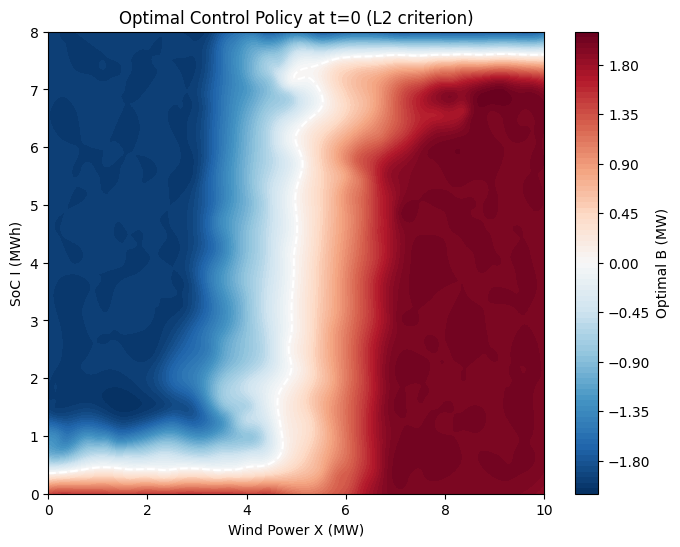

In [9]:
# Cell 8: Plot optimal control map at t=0 (like Figure 3 left)
x_grid, i_grid = np.mgrid[X_min_design:X_max_design:200j, I_min_design:I_max_design:200j]
positions = np.vstack([x_grid.ravel(), i_grid.ravel()]).T
B_pred = control_gps[0].predict(positions).reshape(x_grid.shape)

plt.figure(figsize=(8,6))
plt.contourf(x_grid, i_grid, B_pred, levels=100, cmap='RdBu_r')
plt.colorbar(label='Optimal B (MW)')
plt.contour(x_grid, i_grid, B_pred, levels=[0], colors='white', linestyles='--')
plt.xlabel('Wind Power X (MW)')
plt.ylabel('SoC I (MWh)')
plt.title('Optimal Control Policy at t=0 (L2 criterion)')
plt.show()